<a href="https://colab.research.google.com/github/Sujoy-004/Chat-Analyzer-Pro/blob/main/notebooks/03_sentiment_emotion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Cell 1 : verify environment and available data

In [3]:
import pandas as pd
import numpy as np
import sys
import os
from pathlib import Path

In [4]:
try:
    # Try to load your processed data
    df = pd.read_csv('https://raw.githubusercontent.com/Sujoy-004/Chat-Analyzer-Pro/refs/heads/main/data/processed/example_parsed.csv')
    print("✅ Successfully loaded your processed chat data!")
    print(f"Data shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    print()
    print("Sample data:")
    print(df.head(3).to_string())
    print()
    print("Data types:")
    print(df.dtypes)
    print()

except Exception as e:
    print(f"❌ Error loading data: {e}")

✅ Successfully loaded your processed chat data!
Data shape: (27, 7)
Columns: ['datetime', 'sender', 'message', 'date', 'time', 'hour', 'message_length']

Sample data:
              datetime sender                                                                    message        date      time  hour  message_length
0  2023-12-25 09:30:00  Alice                                                        Merry Christmas! 🎄🎅  2023-12-25  09:30:00     9              19
1  2023-12-25 09:32:00    Bob                 Merry Christmas to you too! Hope you're having a great day  2023-12-25  09:32:00     9              58
2  2023-12-25 09:35:00  Alice  Thanks! Opening presents with family right now Family time is the best ❤️  2023-12-25  09:35:00     9              73

Data types:
datetime          object
sender            object
message           object
date              object
time              object
hour               int64
message_length     int64
dtype: object



In [5]:
# Check for VADER
try:
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    print("✅ VADER Sentiment is available")
    vader_available = True
except ImportError:
    print("❌ VADER Sentiment not installed")
    vader_available = False

❌ VADER Sentiment not installed


In [6]:
# Check for TextBlob
try:
    from textblob import TextBlob
    print("✅ TextBlob is available")
    textblob_available = True
except ImportError:
    print("❌ TextBlob not installed")
    textblob_available = False

✅ TextBlob is available


In [7]:
# Check for transformers (HuggingFace)
try:
    from transformers import pipeline
    print("✅ Transformers (HuggingFace) is available")
    transformers_available = True
except ImportError:
    print("❌ Transformers not installed")
    transformers_available = False

✅ Transformers (HuggingFace) is available


In [8]:
# Check for matplotlib and seaborn for visualization
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
    print("✅ Matplotlib and Seaborn available")
    viz_available = True
except ImportError:
    print("❌ Visualization libraries not available")
    viz_available = False

✅ Matplotlib and Seaborn available


## Cell 2: Install VADER and Import Required Libraries

In [9]:
print("Installing VADER Sentiment...")
!pip install vaderSentiment
print("✅ VADER Sentiment installed")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

Installing VADER Sentiment...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 8.4 MB/s eta 0:00:00
✅ VADER Sentiment installed


In [10]:
# Test VADER
try:
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    vader_analyzer = SentimentIntensityAnalyzer()
    test_text = "I love this amazing day!"
    vader_result = vader_analyzer.polarity_scores(test_text)
    print("✅ VADER working:", vader_result)
except Exception as e:
    print(f"❌ VADER error: {e}")

✅ VADER working: {'neg': 0.0, 'neu': 0.25, 'pos': 0.75, 'compound': 0.8748}


In [11]:
# Test TextBlob
try:
    from textblob import TextBlob
    blob = TextBlob(test_text)
    print("✅ TextBlob working - Polarity:", blob.sentiment.polarity, "Subjectivity:", blob.sentiment.subjectivity)
except Exception as e:
    print(f"❌ TextBlob error: {e}")

✅ TextBlob working - Polarity: 0.625 Subjectivity: 0.75


In [12]:
# Test Transformers (HuggingFace) - this will take time to download
try:
    from transformers import pipeline
    # We'll use a lightweight model for sentiment
    print("✅ Loading HuggingFace sentiment pipeline...")
    hf_analyzer = pipeline("sentiment-analysis",
                          model="cardiffnlp/twitter-roberta-base-sentiment-latest",
                          return_all_scores=True)
    hf_result = hf_analyzer(test_text)
    print("✅ HuggingFace working:", hf_result)
except Exception as e:
    print(f"❌ HuggingFace error: {e}")
    print("Trying alternative model...")
    try:
        hf_analyzer = pipeline("sentiment-analysis", return_all_scores=True)
        hf_result = hf_analyzer(test_text)
        print("✅ HuggingFace (default) working:", hf_result)
    except Exception as e2:
        print(f"❌ HuggingFace (default) error: {e2}")

✅ Loading HuggingFace sentiment pipeline...


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


✅ HuggingFace working: [[{'label': 'negative', 'score': 0.007204313296824694}, {'label': 'neutral', 'score': 0.009917495772242546}, {'label': 'positive', 'score': 0.9828782081604004}]]


In [13]:
df = pd.read_csv('https://raw.githubusercontent.com/Sujoy-004/Chat-Analyzer-Pro/refs/heads/main/data/processed/example_parsed.csv')
df['datetime'] = pd.to_datetime(df['datetime'])

print(f"\n📊 Analyzing {len(df)} messages from {df['sender'].unique()}")
print(f"Date range: {df['datetime'].min()} to {df['datetime'].max()}")


📊 Analyzing 27 messages from ['Alice' 'Bob']
Date range: 2023-12-25 09:30:00 to 2023-12-27 08:15:00


##  Cell 3: Sentiment Analysis Functions

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

In [15]:
print("📥 Downloading sentiment.py from your repository...")
import requests

# Load the sentiment analysis module from GitHub
sentiment_code = requests.get('https://raw.githubusercontent.com/Sujoy-004/Chat-Analyzer-Pro/refs/heads/main/src/analysis/sentiment.py').text

# Execute the code in the global scope to make functions accessible
exec(sentiment_code, globals())

📥 Downloading sentiment.py from your repository...
📊 Sentiment Analysis Module - Chat Analyzer Pro
This module provides comprehensive sentiment analysis for chat data
Usage: import sentiment; sentiment.quick_sentiment_analysis(df)


In [16]:
print("✅ sentiment.py module loaded successfully!")
print("🔧 Available functions:")
print("  ✅ analyze_vader()")
print("  ✅ analyze_textblob()")
print("  ✅ analyze_huggingface()")
print("  ✅ add_sentiment_analysis()")
print("  ✅ get_sentiment_summary()")
print("  ✅ plot_sentiment_analysis()")
print("  ✅ find_extreme_messages()")
print("  ✅ quick_sentiment_analysis()")
print("  ✅ initialize_analyzers()")

✅ sentiment.py module loaded successfully!
🔧 Available functions:
  ✅ analyze_vader()
  ✅ analyze_textblob()
  ✅ analyze_huggingface()
  ✅ add_sentiment_analysis()
  ✅ get_sentiment_summary()
  ✅ plot_sentiment_analysis()
  ✅ find_extreme_messages()
  ✅ quick_sentiment_analysis()
  ✅ initialize_analyzers()


In [17]:
# Load your test data
df = pd.read_csv('https://raw.githubusercontent.com/Sujoy-004/Chat-Analyzer-Pro/refs/heads/main/data/processed/example_parsed.csv')
df['datetime'] = pd.to_datetime(df['datetime'])

print(f"\n📊 Testing on {len(df)} messages from {df['sender'].unique()}")

# Initialize analyzers first before testing individual functions
print("\n🔧 Initializing analyzers for individual function testing...")
initialize_analyzers()


📊 Testing on 27 messages from ['Alice' 'Bob']

🔧 Initializing analyzers for individual function testing...
🚀 Initializing Sentiment Analyzers...
✅ VADER analyzer loaded


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


✅ HuggingFace analyzer loaded
🎯 Sentiment analyzers ready!


In [19]:
sample_messages = [
    "Merry Christmas! 🎄🎅",
    "That sounds wonderful! I'm cooking dinner for everyone today",
    "<Media omitted>",
    "Thanks for sharing your day with me 😊",
    "Good morning! How was your evening?"
]

In [20]:
for i, msg in enumerate(sample_messages, 1):
    print(f"\n📝 Message {i}: '{msg}'")

    # Test VADER
    vader_result = analyze_vader(msg)
    print(f"  🔵 VADER: {vader_result['compound']:.3f} ({categorize_sentiment(vader_result['compound'])})")
    print(f"      Details: pos={vader_result['pos']:.3f}, neu={vader_result['neu']:.3f}, neg={vader_result['neg']:.3f}")

    # Test TextBlob
    tb_result = analyze_textblob(msg)
    print(f"  🟠 TextBlob: {tb_result['polarity']:.3f} ({categorize_sentiment(tb_result['polarity'])})")
    print(f"      Subjectivity: {tb_result['subjectivity']:.3f}")

    # Test HuggingFace
    hf_result = analyze_huggingface(msg)
    dominant = max(hf_result, key=hf_result.get)
    print(f"  🟢 HuggingFace: {dominant} (confidence: {hf_result[dominant]:.3f})")
    print(f"      All scores: {hf_result}")


📝 Message 1: 'Merry Christmas! 🎄🎅'
  🔵 VADER: 0.585 (Positive)
      Details: pos=0.431, neu=0.569, neg=0.000
  🟠 TextBlob: 0.000 (Neutral)
      Subjectivity: 0.000
  🟢 HuggingFace: positive (confidence: 0.968)
      All scores: {'positive': 0.9682372212409973, 'negative': 0.004698131233453751, 'neutral': 0.027064576745033264}

📝 Message 2: 'That sounds wonderful! I'm cooking dinner for everyone today'
  🔵 VADER: 0.611 (Positive)
      Details: pos=0.333, neu=0.667, neg=0.000
  🟠 TextBlob: 1.000 (Positive)
      Subjectivity: 1.000
  🟢 HuggingFace: positive (confidence: 0.989)
      All scores: {'positive': 0.9893565773963928, 'negative': 0.00198520184494555, 'neutral': 0.00865818839520216}

📝 Message 3: '<Media omitted>'
  🔵 VADER: 0.000 (Neutral)
      Details: pos=0.000, neu=1.000, neg=0.000
  🟠 TextBlob: 0.000 (Neutral)
      Subjectivity: 0.000
  🟢 HuggingFace: neutral (confidence: 0.656)
      All scores: {'positive': 0.030994487926363945, 'negative': 0.3133400082588196, 'neutr

In [22]:
# Test the main analysis function on a small subset
print("Testing add_sentiment_analysis() on first 5 messages...")
test_df = df.head(5).copy()
test_df_analyzed = add_sentiment_analysis(test_df, initialize_first=True)

print(f"\n📊 Results Summary:")
print(f"  Original columns: {len(test_df.columns)}")
print(f"  After analysis: {len(test_df_analyzed.columns)}")
print(f"  New columns added: {len(test_df_analyzed.columns) - len(test_df.columns)}")

Testing add_sentiment_analysis() on first 5 messages...
🚀 Initializing Sentiment Analyzers...
✅ VADER analyzer loaded


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


✅ HuggingFace analyzer loaded
🎯 Sentiment analyzers ready!
🔍 Analyzing sentiment for 5 messages...
Running VADER analysis...
Running TextBlob analysis...
Running HuggingFace analysis...
✅ Sentiment analysis complete!

📊 Results Summary:
  Original columns: 7
  After analysis: 20
  New columns added: 13


In [23]:
# Show the new columns
new_columns = [col for col in test_df_analyzed.columns if col not in test_df.columns]
print(f"\n✅ New sentiment columns:")
for col in new_columns:
    print(f"    - {col}")


✅ New sentiment columns:
    - vader_compound
    - vader_pos
    - vader_neu
    - vader_neg
    - vader_sentiment
    - textblob_polarity
    - textblob_subjectivity
    - textblob_sentiment
    - hf_positive
    - hf_negative
    - hf_neutral
    - hf_sentiment
    - consensus_sentiment


In [24]:
# Test summary function
print(f"\n📝 Testing get_sentiment_summary()...")
summary = get_sentiment_summary(test_df_analyzed)
print(f"  Summary keys: {list(summary.keys())}")
print(f"  Sentiment distribution: {summary.get('sentiment_distribution', 'N/A')}")


📝 Testing get_sentiment_summary()...
  Summary keys: ['total_messages', 'sentiment_distribution', 'average_scores', 'by_sender', 'temporal_analysis']
  Sentiment distribution: {'Positive': 4, 'Neutral': 1}


In [25]:
# Test extreme messages function
print(f"\n🎭 Testing find_extreme_messages()...")
extremes = find_extreme_messages(test_df_analyzed, n=2)
print(f"  Found {len(extremes['most_positive'])} most positive messages")
print(f"  Found {len(extremes['most_negative'])} most negative messages")


🎭 Testing find_extreme_messages()...
  Found 2 most positive messages
  Found 2 most negative messages


## Cell 4: Full Sentiment Analysis and Visualization

In [26]:
import requests
sentiment_code = requests.get('https://raw.githubusercontent.com/Sujoy-004/Chat-Analyzer-Pro/refs/heads/main/src/analysis/sentiment.py').text
exec(sentiment_code, globals())

print("✅ sentiment.py module loaded successfully!")

📊 Sentiment Analysis Module - Chat Analyzer Pro
This module provides comprehensive sentiment analysis for chat data
Usage: import sentiment; sentiment.quick_sentiment_analysis(df)
✅ sentiment.py module loaded successfully!


In [27]:
# Load your data
df = pd.read_csv('https://raw.githubusercontent.com/Sujoy-004/Chat-Analyzer-Pro/refs/heads/main/data/processed/example_parsed.csv')
df['datetime'] = pd.to_datetime(df['datetime'])

print(f"📊 Analyzing {len(df)} messages from {df['sender'].unique()}")
print(f"Date range: {df['datetime'].min()} to {df['datetime'].max()}")

📊 Analyzing 27 messages from ['Alice' 'Bob']
Date range: 2023-12-25 09:30:00 to 2023-12-27 08:15:00


🚀 Initializing Sentiment Analyzers...
✅ VADER analyzer loaded


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


✅ HuggingFace analyzer loaded
🎯 Sentiment analyzers ready!
🔍 Analyzing sentiment for 27 messages...
Running VADER analysis...
Running TextBlob analysis...
Running HuggingFace analysis...
✅ Sentiment analysis complete!


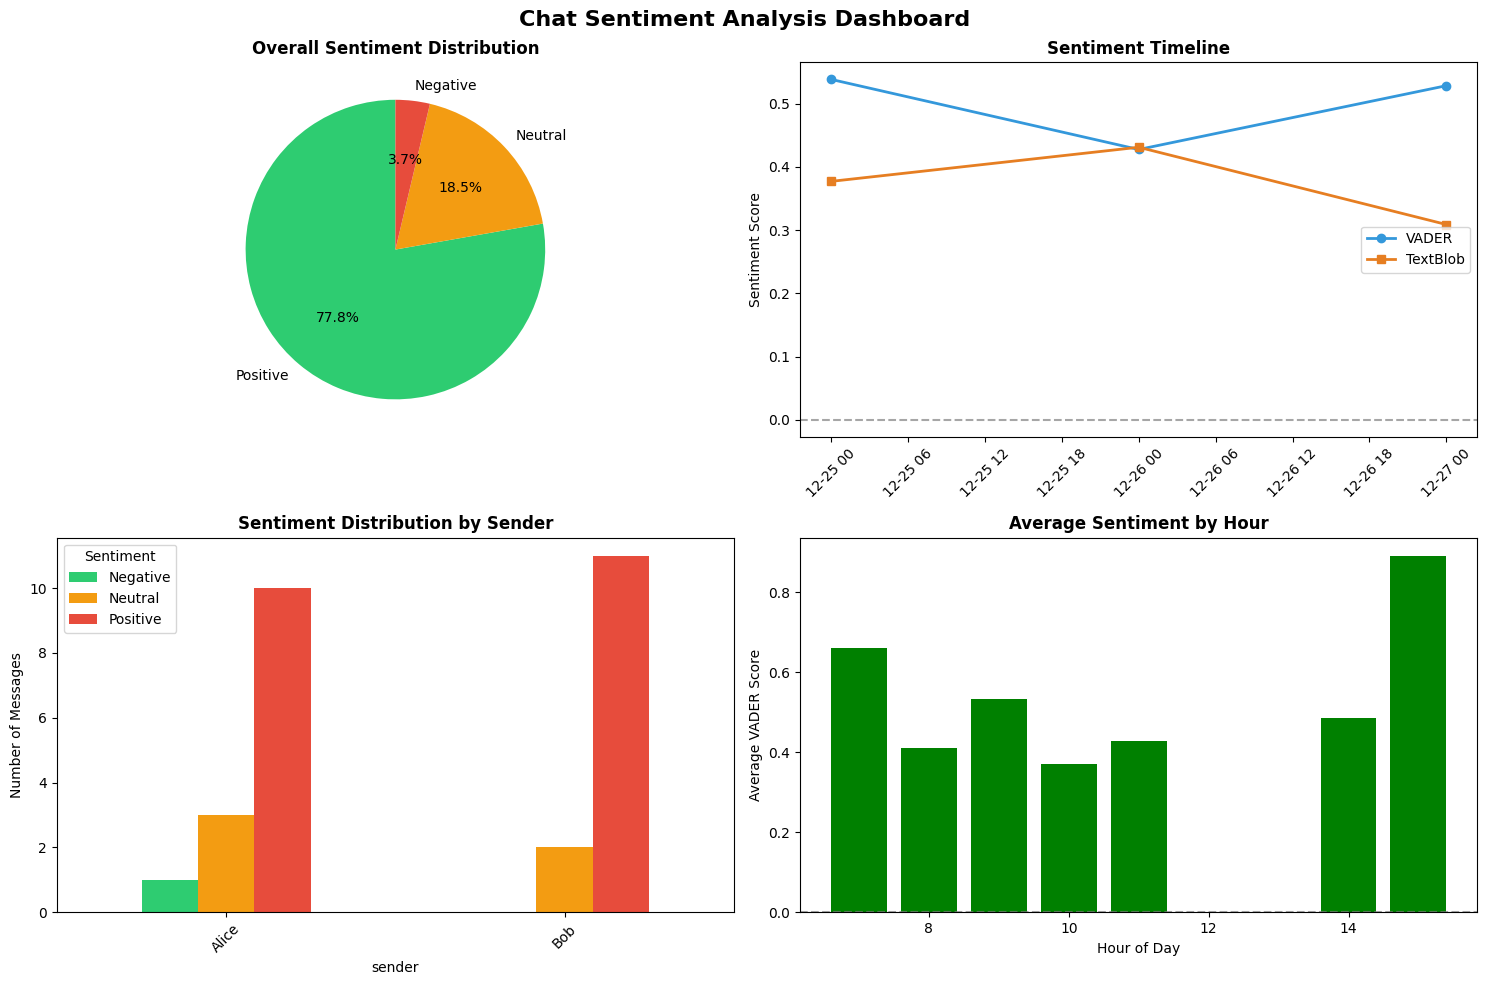


📈 SENTIMENT ANALYSIS RESULTS
Total Messages: 27

🎭 Overall Sentiment Distribution:
  Positive: 21 messages (77.8%)
  Neutral: 5 messages (18.5%)
  Negative: 1 messages (3.7%)

📊 Average Sentiment Scores:
  vader_compound: 0.504 (min: 0.000, max: 0.929)
  textblob_polarity: 0.378 (min: -0.150, max: 1.000)

👥 Sentiment by Sender:
  Alice:
    Messages: 14
    Avg vader_compound: 0.425
    Avg textblob_polarity: 0.204
    Positive: 10 (71.4%)
    Neutral: 3 (21.4%)
    Negative: 1 (7.1%)

  Bob:
    Messages: 13
    Avg vader_compound: 0.588
    Avg textblob_polarity: 0.566
    Positive: 11 (84.6%)
    Neutral: 2 (15.4%)



In [29]:
df_with_sentiment, summary = quick_sentiment_analysis(df, plot=True)

print("\n" + "="*60)
print("📈 SENTIMENT ANALYSIS RESULTS")
print("="*60)

print(f"Total Messages: {summary['total_messages']}")
print(f"\n🎭 Overall Sentiment Distribution:")
for sentiment, count in summary['sentiment_distribution'].items():
    percentage = (count / summary['total_messages']) * 100
    print(f"  {sentiment}: {count} messages ({percentage:.1f}%)")

print(f"\n📊 Average Sentiment Scores:")
for score_type, scores in summary['average_scores'].items():
    print(f"  {score_type}: {scores['mean']:.3f} (min: {scores['min']:.3f}, max: {scores['max']:.3f})")

print(f"\n👥 Sentiment by Sender:")
for sender, data in summary['by_sender'].items():
    print(f"  {sender}:")
    print(f"    Messages: {data['message_count']}")
    for score_type, avg_score in data['avg_scores'].items():
        print(f"    Avg {score_type}: {avg_score:.3f}")
    sentiment_dist = data['sentiment_distribution']
    for sent, count in sentiment_dist.items():
        pct = (count / data['message_count']) * 100
        print(f"    {sent}: {count} ({pct:.1f}%)")
    print()

In [30]:
extreme_messages = find_extreme_messages(df_with_sentiment, n=2)

print("\n" + "="*60)
print("🔍 EXTREME MESSAGES ANALYSIS")
print("="*60)

print("🟢 MOST POSITIVE MESSAGES:")
for i, msg_data in enumerate(extreme_messages['most_positive'], 1):
    print(f"  {i}. Sender: {msg_data['sender']}")
    print(f"     Message: '{msg_data['message']}'")
    print(f"     VADER Score: {msg_data['vader_score']:.3f}")
    print(f"     Sentiment: {msg_data['sentiment']}")
    print()

print("🔴 MOST NEGATIVE MESSAGES:")
for i, msg_data in enumerate(extreme_messages['most_negative'], 1):
    print(f"  {i}. Sender: {msg_data['sender']}")
    print(f"     Message: '{msg_data['message']}'")
    print(f"     VADER Score: {msg_data['vader_score']:.3f}")
    print(f"     Sentiment: {msg_data['sentiment']}")
    print()


🔍 EXTREME MESSAGES ANALYSIS
🟢 MOST POSITIVE MESSAGES:
  1. Sender: Alice
     Message: 'It definitely will be! Thanks for sharing your day with me 😊'
     VADER Score: 0.929
     Sentiment: Positive

  2. Sender: Bob
     Message: 'Merry Christmas to you too! Hope you're having a great day'
     VADER Score: 0.895
     Sentiment: Positive

🔴 MOST NEGATIVE MESSAGES:
  1. Sender: Alice
     Message: '<Media omitted>'
     VADER Score: 0.000
     Sentiment: Neutral

  2. Sender: Alice
     Message: 'Here's our Christmas tree!'
     VADER Score: 0.000
     Sentiment: Neutral



In [31]:
# Show final data structure
print("📋 FINAL DATA STRUCTURE:")
print(f"Shape: {df_with_sentiment.shape}")
print(f"Sentiment columns added by your module:")
sentiment_columns = [col for col in df_with_sentiment.columns if any(word in col.lower()
                    for word in ['vader', 'textblob', 'hf', 'sentiment'])]
for col in sentiment_columns:
    print(f"  ✅ {col}")

📋 FINAL DATA STRUCTURE:
Shape: (27, 20)
Sentiment columns added by your module:
  ✅ vader_compound
  ✅ vader_pos
  ✅ vader_neu
  ✅ vader_neg
  ✅ vader_sentiment
  ✅ textblob_polarity
  ✅ textblob_subjectivity
  ✅ textblob_sentiment
  ✅ hf_positive
  ✅ hf_negative
  ✅ hf_neutral
  ✅ hf_sentiment
  ✅ consensus_sentiment
